## Import libraries and data

In [1]:
import causalml
from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor
from causalml.inference.meta import BaseRRegressor
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import dowhy as dw
from IPython.display import Image, display
from xgboost import XGBRegressor
from statsmodels.api import OLS

/home/baold1/yes/envs/dowhy/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
csv_path = 'kidney_stone_data.csv'
df = pd.read_csv(csv_path)

In [3]:
df

,treatment,stone_size,success
0,B,large,1
1,A,large,1
2,A,large,0
3,A,large,1
4,A,large,1
...,...,...,...
695,B,small,0
696,B,small,1
697,B,small,1
698,A,large,1


In [4]:
# convert treatment and stone_size to binary
df['treatment'] = df['treatment'].apply(lambda x: 1 if x == 'A' else 0)
df['stone_size'] = df['stone_size'].apply(lambda x: 1 if x == 'large' else 0)

## Visual inspection

<Axes: xlabel='treatment', ylabel='success'>

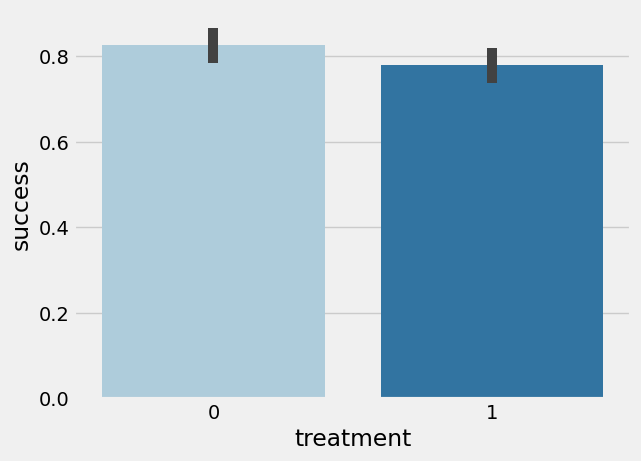

In [5]:
## plot the success rate of both treatments
sns.barplot(x='treatment', y='success', data=df)

<Axes: xlabel='stone_size', ylabel='success'>

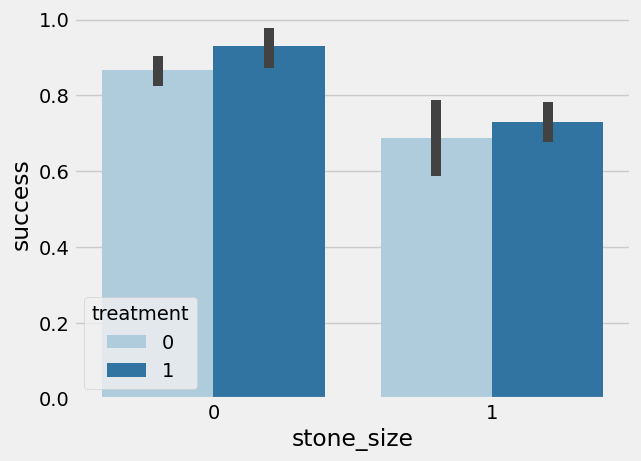

In [6]:
## plot the success rate of both treatments, grouped by stone_size
sns.barplot(x='stone_size', y='success', hue='treatment', data=df)

## Solving using regular Machine Learning (OLS)

In [7]:
# fit OLS model with target variable as success and dependent variables as stone_size and treatment
ols = OLS(df['success'], df[['stone_size', 'treatment']]).fit()

In [8]:
# print the summary of the model
print(ols.summary())

                                 OLS Regression Results                                
Dep. Variable:                success   R-squared (uncentered):                   0.400
Model:                            OLS   Adj. R-squared (uncentered):              0.399
Method:                 Least Squares   F-statistic:                              233.0
Date:                Tue, 28 Mar 2023   Prob (F-statistic):                    3.07e-78
Time:                        16:27:35   Log-Likelihood:                         -737.41
No. Observations:                 700   AIC:                                      1479.
Df Residuals:                     698   BIC:                                      1488.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## Solve the problem using DoWhy package

In [9]:
gml_graph = ('graph [directed 1 '
             'node [id "0" label "stone_size"] '
             'node [id "1" label "treatment"] '
             'node [id "2" label "success"] '
             'edge [source "0" target "1"] '
             'edge [source "0" target "2"] '
             'edge [source "1" target "2"] ]')

In [10]:
model = dw.CausalModel(
    data=df,
    graph=gml_graph,
    treatment='treatment',
    outcome='success',
)

identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                             
────────────(E[success|stone_size])
d[treatment]                       
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→success then P(success|treatment,stone_size,U) = P(success|treatment,stone_size)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



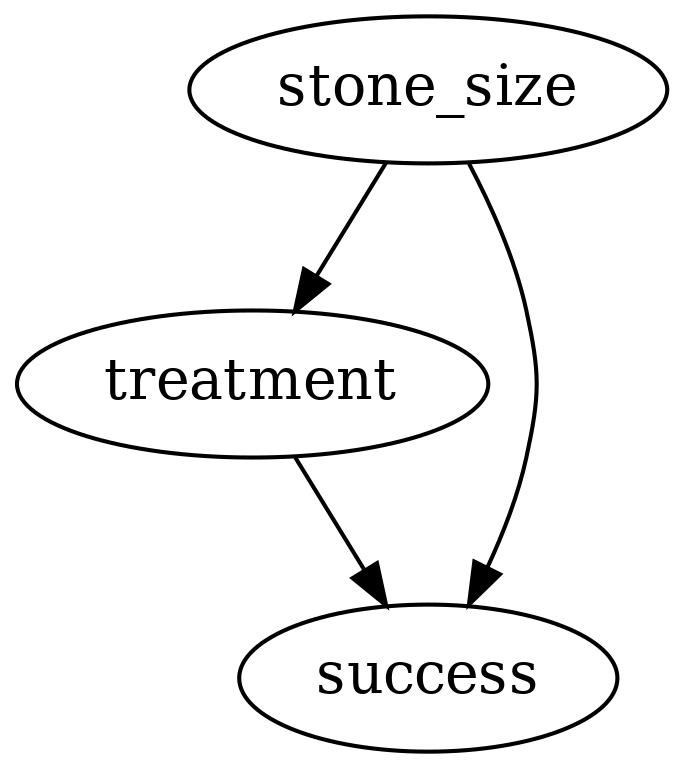

In [11]:
model.view_model()
display(Image(filename="causal_model.png"))

In [12]:
methods = ['backdoor.propensity_score_stratification', 
            'backdoor.propensity_score_matching',
            'backdoor.propensity_score_weighting',
            'backdoor.linear_regression'
            ]

In [13]:
for method in methods:
    try:
        print(f'use method: {method}')
        estimate = model.estimate_effect(identified_estimand,
                                        method_name=method,
                                        test_significance=True)
        print(f'Estimate for {method}: {estimate.value}')
    except Exception as e:
        print(f'Error for {method}: {e}')

use method: backdoor.propensity_score_stratification
Estimate for backdoor.propensity_score_stratification: 0.053671217385603764
use method: backdoor.propensity_score_matching
Estimate for backdoor.propensity_score_matching: -0.13714285714285715
use method: backdoor.propensity_score_weighting
Estimate for backdoor.propensity_score_weighting: 0.05033768525728666
use method: backdoor.linear_regression
Estimate for backdoor.linear_regression: 0.05383557024347474


## Solve the problem using CausalML

In [14]:
X = df[['stone_size']]
treatment = df['treatment']
y = df['success']

lr = LRSRegressor()
te, lb, ub = lr.estimate_ate(X, treatment, y)
print('Average Treatment Effect (Linear Regression): {:.6f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

xg = XGBTRegressor(random_state=42)
te, lb, ub = xg.estimate_ate(X, treatment, y)
print('Average Treatment Effect (XGBoost): {:.6f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

nn = MLPTRegressor(hidden_layer_sizes=(10, 10),
                 learning_rate_init=.1,
                 early_stopping=True,
                 random_state=42)
te, lb, ub = nn.estimate_ate(X, treatment, y)
print('Average Treatment Effect (Neural Network (MLP)): {:.6f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

xl = BaseXRegressor(learner=XGBRegressor(random_state=42))
te, lb, ub = xl.estimate_ate(X, treatment, y)
print('Average Treatment Effect (BaseXRegressor using XGBoost): {:.6f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

rl = BaseRRegressor(learner=XGBRegressor(random_state=42))
te, lb, ub =  rl.estimate_ate(X=X, treatment=treatment, y=y)
print('Average Treatment Effect (BaseRRegressor using XGBoost): {:.6f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

Average Treatment Effect (Linear Regression): 0.053836 (-0.01, 0.12)
Average Treatment Effect (XGBoost): 0.053622 (-0.00, 0.11)
Average Treatment Effect (Neural Network (MLP)): 0.078932 (0.02, 0.14)
Average Treatment Effect (BaseXRegressor using XGBoost): 0.053670 (-0.00, 0.11)
Average Treatment Effect (BaseRRegressor using XGBoost): 0.054454 (0.05, 0.06)
